In [1]:
import numpy as np
from numpy import linalg
from scipy.optimize import minimize
from scipy.optimize import least_squares
import sklearn
from sklearn.decomposition import KernelPCA
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
from numpy.random import multivariate_normal

In [88]:
def PODMM_Train(f,g,M):
    f1 = np.shape(f)[0]
    f2 = np.shape(f)[1]
    fvals = []
    gvals = []
    easymeans1 = np.mean(f,axis=1)
    easymeans2 = np.mean(g,axis=1)
    easymeans1 = easymeans1.reshape(f1,1)
    easymeans2 = easymeans2.reshape(np.shape(g)[0],1)
    for i in range(np.shape(f)[0]):
        f[:][i] = f[:][i] - easymeans1[i]
    for i in range(np.shape(g)[0]):
        g[:][i] = g[:][i] - easymeans2[i]
    W = np.concatenate((f,g))
    RSV_computed = []
    U,W_svd,V = np.linalg.svd(W,compute_uv=True)
    for i in range(M):
        x = V[:,i]
        RSV_computed.append(np.dot(W,x))
    RSV_computed = np.array(RSV_computed).T
    for i in range(M):
        fvals.append(RSV_computed[:f1,i])
        gvals.append(RSV_computed[f1:,i])
    fvals,gvals = np.array(fvals),np.array(gvals)
    return fvals.T,gvals.T,easymeans1,easymeans2

In [89]:
def PODMM_Train_KPCA(f,g,M,ker):
    f1 = np.shape(f)[0]
    f2 = np.shape(f)[1]
    fvals = []
    gvals = []
    easymeans1 = np.mean(f,axis=1)
    easymeans2 = np.mean(g,axis=1)
    easymeans1 = easymeans1.reshape(f1,1)
    easymeans2 = easymeans2.reshape(np.shape(g)[0],1)
    for i in range(np.shape(f)[0]):
        f[:][i] = f[:][i] - easymeans1[i]
    for i in range(np.shape(g)[0]):
        g[:][i] = g[:][i] - easymeans2[i]
    W = np.concatenate((f,g))
    components = KernelPCA(n_components=M,kernel=ker)
    V = components.fit_transform(W)
    for i in range(M):
        fvals.append(V[:f1,i])
        gvals.append(V[f1:,i])
    fvals,gvals = np.array(fvals),np.array(gvals)
    return fvals.T,gvals.T,easymeans1,easymeans2

In [90]:
def PODMM_Predict(g_test,zeta_f,zeta_g,f_bar,g_bar,M):
    alpha_PODMM = []
    g_test = g_test.reshape(-1,1)
    objective_func = lambda y:(g_test-(g_bar + np.dot(zeta_g,y.T).reshape(-1,1))).flatten()
    y0 = np.random.random(M)
    gam = least_squares(objective_func,y0)
    alph = gam.x
    return f_bar + np.dot(zeta_f,alph.T).reshape(-1,1)

In [91]:
def ADRSource(Lx, Nx, Source, omega, v, kappa):
    """
    Solve the advection-diffusion-reaction equation
    input:
    Lx: float, the right end of x
    Nx: int, nunber of x
    Source: 1d array of size Nx
    omega: 1d array of size Nx
    v: 1d array of size Nx+1
    kappa: 1d array of size Nx
    return:
    Solution: 1d array of size Nx
    Q: float, quantiy of interest
    """
    Source = np.full((Nx),Source)
    omega = np.full((Nx),omega)
    v = np.full((Nx),v)
    kappa = np.full((Nx),kappa)
    A = sparse.dia_matrix((Nx,Nx))   
    dx = Lx/(Nx-1)
    i2dx2 = 1.0/(dx*dx)
    #fill diagonal of A
    A.setdiag(2*i2dx2*omega + np.sign(v)*v/dx + kappa)
    #fill off diagonals of A
    A.setdiag(-i2dx2*omega[1:Nx] + 0.5*(1-np.sign(v[1:Nx]))*v[1:Nx]/dx,1)
    A.setdiag(-i2dx2*omega[0:(Nx-1)] - 0.5*(np.sign(v[0:(Nx-1)])+1)*v[0:(Nx-1)]/dx,-1)
    #solve A x = Source
    Solution = linalg.spsolve(A,Source)
    # Trapezoid rule
    Q = np.sum(Solution[1:-1]*kappa[1:-1]*dx) + \
        Solution[0]*kappa[0]*dx/2 + Solution[-1]*kappa[-1]*dx/2
    return Solution, Q

In [92]:
def lazy(mean,std):
    A = [[1,-1],[1,1]]
    e1 = np.sqrt(12)*std
    e2 = 2*mean
    b = [e1,e2]
    return np.linalg.solve(A,b)

In [93]:
v_a_b = lazy(10,1)
omega_a_b = lazy(20,2)
k_l_a_b = lazy(2,.2)
k_h_a_b = lazy(.1,.01)
q_a_b = lazy(1,.1)

In [94]:
v_sample = np.random.uniform(v_a_b[0],v_a_b[1],200)
omega_sample = np.random.uniform(omega_a_b[0],omega_a_b[1],200)
k_l_sample = np.random.uniform(k_l_a_b[0],k_l_a_b[1],200)
k_h_sample = np.random.uniform(k_h_a_b[0],k_h_a_b[1],200)
q_sample = np.random.uniform(q_a_b[0],q_a_b[1],200)
x = np.linspace(0,1,50)
y = np.linspace(0,1,2000)

In [95]:
G_soln = []
for i in range(200):
    G_soln.append(ADRSource(1,50,q_sample[i]*x*(10-x),omega_sample[i],v_sample[i],k_l_sample[i])[0])
G_soln = np.array(G_soln)
F_soln = []
for i in range(200):
    F_soln.append(ADRSource(1,2000,q_sample[i]*y*(10-y),omega_sample[i],v_sample[i],k_l_sample[i])[0])
F_soln = np.array(F_soln)
print(np.shape(F_soln.T))
print(np.shape(G_soln.T))

C:\Users\Budde\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


(2000, 200)
(50, 200)


In [42]:
np.shape(F_soln[1])

(2000,)

In [96]:
f_POD,g_POD,f_means,g_means=PODMM_Train(F_soln.T,G_soln.T,20)

In [97]:
v_test = np.random.uniform(v_a_b[0],v_a_b[1],1)
omega_test = np.random.uniform(omega_a_b[0],omega_a_b[1],1)
k_l_test = np.random.uniform(k_l_a_b[0],k_l_a_b[1],1)
k_h_test = np.random.uniform(k_h_a_b[0],k_h_a_b[1],1)
q_test = np.random.uniform(q_a_b[0],q_a_b[1],1)


In [98]:
g_test = ADRSource(1,50,q_test*x*(10-x),omega_test,v_test,k_l_test)[0]
f_test = ADRSource(1,2000,q_test*y*(10-y),omega_test,v_test,k_l_test)[0]

In [99]:
pred = PODMM_Predict(g_test,f_POD,g_POD,f_means,g_means,20)
pred

array([[3.82002642e-05],
       [7.64134119e-05],
       [1.14639376e-04],
       ...,
       [2.89537243e-04],
       [1.93188761e-04],
       [9.66763852e-05]])

In [100]:
print(np.linalg.norm(pred - f_test,ord=2))

21.022342943802013


In [85]:
f_kPOD,g_kPOD,fk_means,gk_means = PODMM_Train_KPCA(F_soln.T,G_soln.T,30,'cosine')

In [86]:
pred2 = PODMM_Predict(g_test,f_kPOD,g_kPOD,fk_means,gk_means,30)

In [87]:
print(np.linalg.norm(pred2-f_test,ord=2))

18.299077376062904


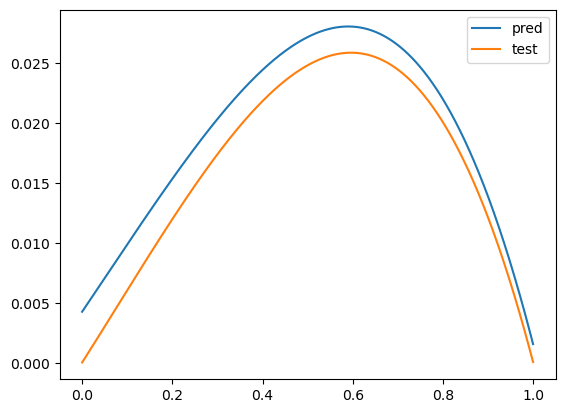

In [80]:
%matplotlib inline
from matplotlib import pyplot as plt
#Do this later
plt.plot(y,pred2,label='pred')
plt.plot(y,f_test,label='test')
plt.legend()
plt.show()


In [35]:
print(pred[0],f_test[0])

[3.43598632e-05] 3.435969647378679e-05
